In [1]:
import serial
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fft2(x):
    N = len(x)
        
    if N == 1:
        return x
    else:
        X_even = fft2(x[0::2])
        X_odd = fft2(x[1::2])

    X = np.zeros(N, dtype=complex)

    for m in range(N):
        m_alias = m % (N//2)
        X[m] = X_even[m_alias] + np.exp(-2j * np.pi * m / N) * X_odd[m_alias]

    return X

def send_and_receive(x, ser):
    received_values = []

    for i in range(len(x)):
        encoded_float = f'{x[i]}\n'.encode()
        ser.write(encoded_float)

        # Wait until data is received
        while ser.in_waiting == 0:
            pass

        # Read and decode the response
        while ser.in_waiting > 0:
            received = ser.readline().decode('utf-8').strip()
            received_values.append(received)

    return [float(i) for i in received_values]

In [3]:
# open the serial port (modify COM port as needed)
ser = serial.Serial('COM4', 115200)
print('waiting for auto-reset...') # arduino resets when serial connection is made, so wait for it to boot up
time.sleep(2)
print('waiting done')

waiting for auto-reset...
waiting done


In [4]:
sr = 2**11 # sampling rate (power of 2 for radix-2)
ts = 1.0/sr # sampling interval
number_of_samples = 2**13 # power of 2 for DFT radix-2 and at least the same value as sr

t = np.arange(0, number_of_samples*ts, ts) # time vector
print(f'len(t) = {len(t)}')

len(t) = 8192


In [5]:
freq = 10 # frequency of the signal (in Hz)
signal = np.sin(2*np.pi*freq*t)
noise = 0.05*np.sin(2*np.pi*200*t) + 0.08*np.sin(2*np.pi*300*t) + 0.1*np.sin(2*np.pi*400*t) # random frequencies

x = signal + noise
x = [round(i, 6) for i in x] # ensuring that arduino can handle the float values

sending and receiving data...
sent 8192 values, received 8192 values


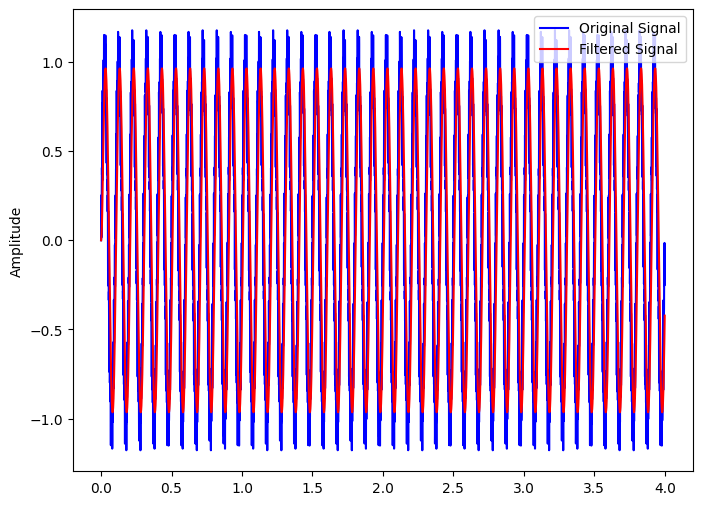

In [6]:
# send and receive through filter
print('sending and receiving data...')
received_values = send_and_receive(x, ser)

print(f'sent {len(x)} values, received {len(received_values)} values')

ser.close()

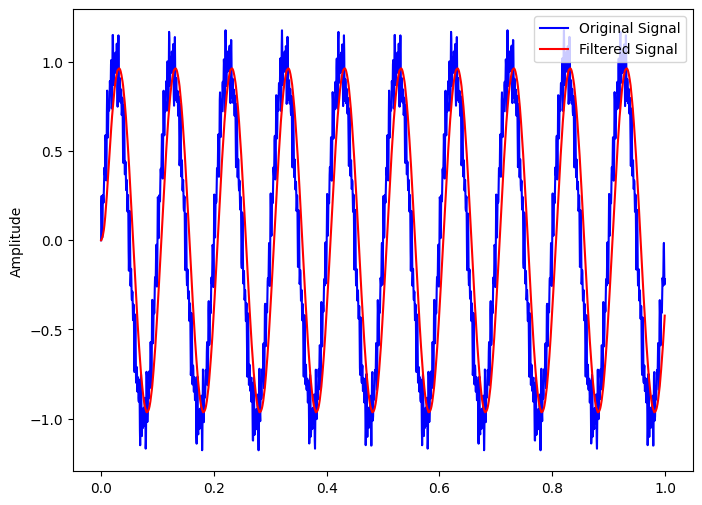

In [8]:
plt.figure(figsize = (8, 6))
plt.plot(t[0:sr], x[0:sr], 'b') # only plot first period of samples
plt.ylabel('Amplitude')

plt.plot(t[0:sr], received_values[0:sr], 'r') # only plot first period of samples

plt.legend(['Original Signal', 'Filtered Signal'])

plt.show()

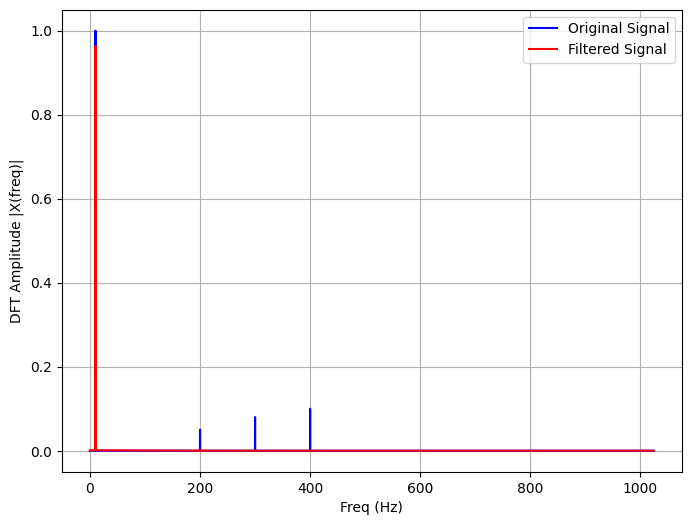

In [9]:
X = fft2(x)
N = len(X)
X_mag = abs(X)/N
f = np.linspace(0, sr, N)[0:N//2 + 1]
X_mag = 2 * X_mag[0:N//2 + 1]
X_mag[0] = X_mag[0]/2

plt.figure(figsize = (8, 6))
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.plot(f, X_mag, 'b')

Y = fft2(received_values)
Y_mag = abs(Y)/N
Y_mag = 2 * Y_mag[0:N//2 + 1]
Y_mag[0] = Y_mag[0]/2

plt.plot(f, Y_mag, 'r')

plt.legend(['Original Signal', 'Filtered Signal'])
plt.grid(True)
plt.show()